### Bibliotecas

In [1]:
import numpy as np
import rasterio
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


### Parâmetros

In [2]:
# Caminho para o arquivo do MDT
filepath = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP_corrigido_projetado.tif'

In [4]:
# Função para carregar o MDT
def load_mdt(filepath):
    with rasterio.open(filepath) as src:
        mdt = src.read(1)
        nodata = src.nodata
        profile = src.profile
    return mdt, nodata, profile

# Função para tratar valores nodata
def handle_nodata(mdt, nodata):
    if nodata is not None:
        mdt[mdt == nodata] = np.nan
    return mdt

# Função para calcular as estatísticas descritivas
def calculate_statistics(mdt):
    mdt_flat = mdt.flatten()
    mdt_flat = mdt_flat[~np.isnan(mdt_flat)]  # Remover NaNs para análise
    stats = {
        'mean': np.mean(mdt_flat),
        'median': np.median(mdt_flat),
        'std_dev': np.std(mdt_flat),
        'variance': np.var(mdt_flat),
        'coeff_var': np.std(mdt_flat) / np.mean(mdt_flat),
        'skewness': skew(mdt_flat),
        'kurtosis': kurtosis(mdt_flat),
        'max_value': np.max(mdt_flat)
    }
    return stats

# Função para calcular a declividade
def calculate_slope(mdt, profile):
    x, y = np.gradient(mdt, profile['transform'][0], profile['transform'][4])
    slope = np.sqrt(x**2 + y**2)
    return slope

# Função para visualizar o MDT, declividade e histograma das elevações
def visualize_data(mdt, slope):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Aumentar a área dos gráficos
    
    ax[0].imshow(mdt, cmap='terrain')
    ax[0].set_title('MDT')
    
    ax[1].imshow(slope, cmap='viridis')
    ax[1].set_title('Declividade')
    
    ax[2].hist(mdt.flatten(), bins=50, color='grey', edgecolor='black')
    ax[2].set_title('Histograma de Elevações')
    
    plt.tight_layout()  # Ajustar layout para melhor visualização
    plt.show()

# Função para verificar as dimensões e valores dos eixos X e Y
def check_coordinates(profile):
    width = profile['width']
    height = profile['height']
    transform = profile['transform']
    
    x = np.arange(0, width) * transform[0] + transform[2]
    y = np.arange(0, height) * transform[4] + transform[5]
    
    print(f"Dimensões do DEM: {width} x {height}")
    print(f"Coordenadas X variam de {x.min()} a {x.max()}")
    print(f"Coordenadas Y variam de {y.min()} a {y.max()}")

In [ ]:
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np

def visualize_3d_geo(mdt, profile):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    width = profile['width']
    height = profile['height']
    transform = profile['transform']
    crs = profile['crs']  # Deve estar presente e corretamente definido (ex: EPSG:31983, EPSG:32723 etc.)

    # Gerar grid de coordenadas UTM
    x = np.arange(0, width) * transform[0] + transform[2]
    y = np.arange(0, height) * transform[4] + transform[5]
    x, y = np.meshgrid(x, y)

    # Converter UTM para Latitude/Longitude
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(x, y)

    # Matriz de elevação
    z = np.nan_to_num(mdt)

    # Subamostragem para melhorar desempenho
    stride = 5
    lon = lon[::stride, ::stride]
    lat = lat[::stride, ::stride]
    z = z[::stride, ::stride]

    # Clipping para evitar extremos visuais
    z = np.clip(z, 0, 1200)

    # Visualização
    surf = ax.plot_surface(lon, lat, z, cmap='terrain', edgecolor='none',
                           alpha=0.95, shade=True, antialiased=True)

    ax.set_title('Visualização 3D do MDT com Coordenadas Geográficas')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Elevação (m)')
    ax.view_init(elev=45, azim=135)

    plt.tight_layout()
    plt.show()





In [ ]:

# Função principal
def main():
    # Caminho para o arquivo do MDT
    #filepath = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/Produção novo DEM SP/Novo_DEM_SP.tif'
    #'/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP.tif'
    
    # Carregar o MDT
    mdt, nodata, profile = load_mdt(filepath)
    print(profile)
    
    # Tratar valores nodata
    mdt = handle_nodata(mdt, nodata)
    
    # Calcular estatísticas descritivas
    stats = calculate_statistics(mdt)
    print("Estatísticas Descritivas:")
    for key, value in stats.items():
        print(f"{key}: {value:.3f}")
    
    # Calcular declividade
    slope = calculate_slope(mdt, profile)
    
    # Visualizar MDT, declividade e histograma
    visualize_data(mdt, slope)
    
    # Verificar coordenadas
    check_coordinates(profile)
    
    # Visualizar MDT em 3D
    visualize_3d(mdt, profile)

if __name__ == "__main__":
    main()

In [ ]:
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter

 # Carregar o MDT
mdt, nodata, profile = load_mdt(filepath)
print(profile)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

width = profile['width']
height = profile['height']
transform = profile['transform']
crs = profile['crs']  # Deve estar presente e corretamente definido (ex: EPSG:31983, EPSG:32723 etc.)

# Gerar grid de coordenadas UTM
x = np.arange(0, width) * transform[0] + transform[2]
y = np.arange(0, height) * transform[4] + transform[5]
x, y = np.meshgrid(x, y)

# Converter UTM para Latitude/Longitude
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(x, y)

# Matriz de elevação
z = np.nan_to_num(mdt)

# Subamostragem para melhorar desempenho
#stride = 5
#lon = lon[::stride, ::stride]
#lat = lat[::stride, ::stride]
#z = z[::stride, ::stride]

# Clipping para evitar extremos visuais
z = np.clip(z, 700, 1200)

z_smooth = gaussian_filter(z, sigma=2)

# Visualização
norm = Normalize(vmin=700, vmax=1200)
surf = ax.plot_surface(lon, lat, z_smooth, cmap='terrain', edgecolor='none',
                           alpha=0.95, shade=True, norm=norm, antialiased=True)

#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Elevação (m)')
#ax.set_title('Visualização 3D do MDT com Coordenadas Geográficas')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.set_zlim(700, 1200)
ax.set_zlabel('Elevação (m)')
ax.view_init(elev=60, azim=-45)

#plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.87, top=0.95, bottom=0.05)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        if renderer is None:
            return 0  # fallback para evitar erro
        xs3d, ys3d, zs3d = self._verts3d
        _, _, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        return np.min(zs)



{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 1597, 'height': 2399, 'count': 1, 'crs': CRS.from_wkt('PROJCS["SIRGAS 2000 / UTM zone 23S",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4674"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-45],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","31983"]]'), 'transform': Affine(29.960614723432364, 0.0, 313302.03886734426,
       0.0, -29.960614723432364, 7416368.206745678), 'blockxsize': 1597, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


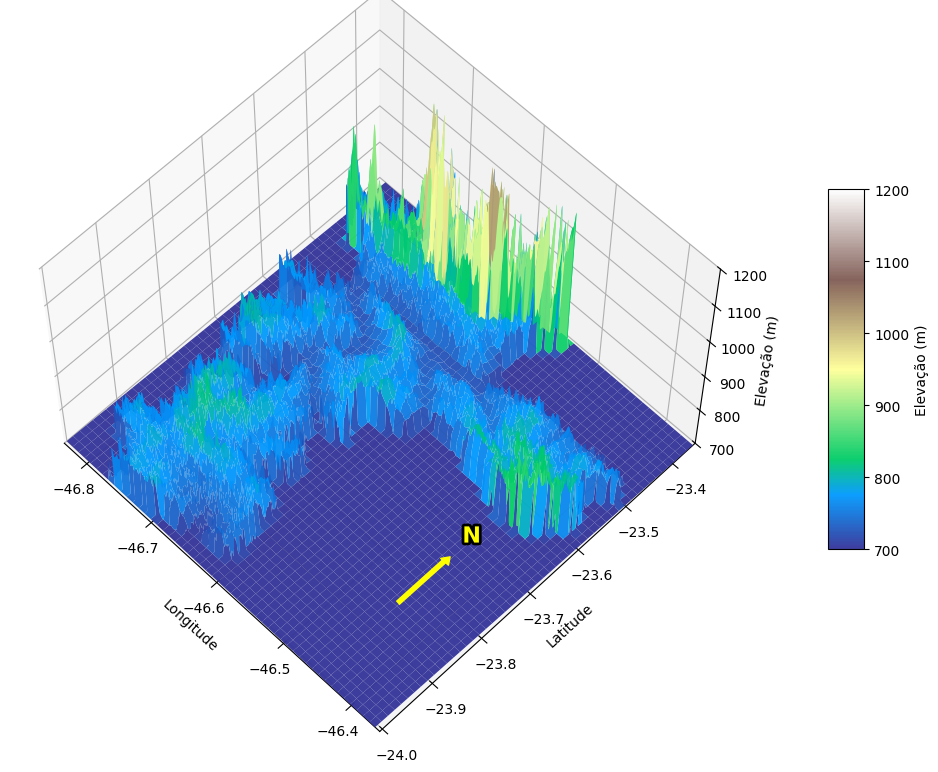

In [14]:
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter
from matplotlib.patheffects import withStroke
from mpl_toolkits.mplot3d.art3d import Line3D
from matplotlib.patheffects import withStroke
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

 # Carregar o MDT
mdt, nodata, profile = load_mdt(filepath)
print(profile)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

width = profile['width']
height = profile['height']
transform = profile['transform']
crs = profile['crs']  # Deve estar presente e corretamente definido (ex: EPSG:31983, EPSG:32723 etc.)

# Gerar grid de coordenadas UTM
x = np.arange(0, width) * transform[0] + transform[2]
y = np.arange(0, height) * transform[4] + transform[5]
x, y = np.meshgrid(x, y)

# Converter UTM para Latitude/Longitude
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(x, y)

# Matriz de elevação
z = np.nan_to_num(mdt)

# Subamostragem para melhorar desempenho
#stride = 5
#lon = lon[::stride, ::stride]
#lat = lat[::stride, ::stride]
#z = z[::stride, ::stride]

# Clipping para evitar extremos visuais
z = np.clip(z, 700, 1200)

z_smooth = gaussian_filter(z, sigma=2)

from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d

        # ✅ usar renderer.M apenas se existir
        if hasattr(renderer, "M"):
            xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
            self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
            super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        if renderer is None or not hasattr(renderer, "M"):
            return 0
        xs3d, ys3d, zs3d = self._verts3d
        _, _, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        return np.min(zs)


# Visualização
norm = Normalize(vmin=700, vmax=1200)
surf = ax.plot_surface(lon, lat, z_smooth, cmap='terrain', edgecolor='none',
                           alpha=0.95, shade=True, norm=norm, antialiased=True)

#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Elevação (m)')
#ax.set_title('Visualização 3D do MDT com Coordenadas Geográficas')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.set_zlim(700, 1200)
ax.set_zlabel('Elevação (m)')
ax.view_init(elev=60, azim=-45)

# --- Legenda de Elevação ---
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('Elevação (m)')

#plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.87, top=0.95, bottom=0.05)

# --- Seta do Norte (Versão com Posição Fixa e Alta) ---

# 1. Definir a posição e o comprimento da seta em Longitude e Latitude
arrow_lon = -46.30
arrow_lat_start = -24.05
arrow_lat_end = arrow_lat_start + 0.08  # Aponta para o norte

# 2. Definir uma elevação Z FIXA que seja MAIOR que o ponto mais alto do seu mapa.
#    Seu mapa vai até 1200m, então vamos colocar a seta em 1300m para garantir.
arrow_z = 1300

# 3. Desenhar o CORPO da seta com ax.plot.
#    Usamos uma cor bem viva (amarelo) e uma linha mais grossa para destaque.
#ax.plot(
#    [arrow_lon, arrow_lon],                 # X (start, end)
#    [arrow_lat_start, arrow_lat_end],       # Y (start, end)
#    [arrow_z, arrow_z],                     # Z (start, end)
#    color='yellow',
#    linewidth=4,
#    solid_capstyle='round' # Deixa as pontas da linha arredondadas
#)
from mpl_toolkits.mplot3d.art3d import Line3D

arrow_body = Line3D(
    [arrow_lon, arrow_lon],
    [arrow_lat_start, arrow_lat_end],
    [arrow_z, arrow_z],
    color='yellow',
    linewidth=4,
    zorder=100,           # tentativa de sobreposição
    alpha=1.0
)
ax.add_line(arrow_body)


# 4. Desenhar a PONTA da seta com ax.scatter.
#    É uma maneira simples e eficaz de criar uma ponta de seta triangular.
#ax.scatter(
#    arrow_lon,
#    arrow_lat_end,
#    arrow_z,
#    color='yellow',
#    marker='^', # Marcador de triângulo apontando para cima
#    s=200       # Tamanho do marcador
#)

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --- Criar a ponta da seta manualmente ---
def add_arrow_head(ax, lon, lat, z, length=0.01, width=0.005, direction='N', color='yellow'):
    """
    Desenha uma ponta de seta (triângulo) orientada na direção desejada.
    """
    if direction.upper() == 'N':
        p1 = [lon, lat + length, z]
        p2 = [lon - width, lat, z]
        p3 = [lon + width, lat, z]
    elif direction.upper() == 'S':
        p1 = [lon, lat - length, z]
        p2 = [lon - width, lat, z]
        p3 = [lon + width, lat, z]
    elif direction.upper() == 'E':
        p1 = [lon + length, lat, z]
        p2 = [lon, lat - width, z]
        p3 = [lon, lat + width, z]
    elif direction.upper() == 'W':
        p1 = [lon - length, lat, z]
        p2 = [lon, lat - width, z]
        p3 = [lon, lat + width, z]
    else:
        raise ValueError("Direção inválida. Use 'N', 'S', 'E' ou 'W'.")

    triangle = [p1, p2, p3]
    tri = Poly3DCollection([triangle], color=color)
    ax.add_collection3d(tri)

add_arrow_head(ax, arrow_lon, arrow_lat_end, arrow_z, direction='N')


# 5. Adicionar o texto "N" na mesma elevação fixa
text_effect = withStroke(linewidth=4, foreground='black')
ax.text(
    arrow_lon,
    arrow_lat_end + 0.05, # Um pouco acima da ponta da seta
    arrow_z,
    'N',
    color='yellow', # Mudado para amarelo para combinar com a seta
    fontsize=16,
    fontweight='bold',
    ha='center',
    va='center',
    path_effects=[text_effect]
)

# Restaurar os limites do gráfico para focar no MDT
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_zlim(700, 1200)

plt.show()

In [ ]:
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter
from matplotlib.patheffects import withStroke
from mpl_toolkits.mplot3d.art3d import Line3D

# --- Função para desenhar a seta do Norte ---
def draw_north_arrow(ax, lon, lat, z, color='yellow', delta_deg=0.08):
    arrow_lon = lon.min() + (lon.max() - lon.min()) * 0.05
    arrow_lat_start = lat.min() + (lat.max() - lat.min()) * 0.05
    arrow_lat_end = arrow_lat_start + delta_deg
    arrow_z = z.max() + 100  # Coloca acima do relevo

    # Corpo da seta
    arrow_body = Line3D(
        [arrow_lon, arrow_lon],
        [arrow_lat_start, arrow_lat_end],
        [arrow_z, arrow_z],
        color=color,
        linewidth=4,
        solid_capstyle='round'
    )
    ax.add_line(arrow_body)

    # Ponta da seta
    ax.scatter(
        arrow_lon,
        arrow_lat_end,
        arrow_z,
        color=color,
        marker='^',
        s=200
    )

    # Letra "N"
    text_effect = withStroke(linewidth=4, foreground='black')
    ax.text(
        arrow_lon,
        arrow_lat_end + 0.05,
        arrow_z,
        'N',
        color=color,
        fontsize=16,
        fontweight='bold',
        ha='center',
        va='center',
        path_effects=[text_effect]
    )

# --- Carregar MDT ---
mdt, nodata, profile = load_mdt(filepath)
print(profile)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

width = profile['width']
height = profile['height']
transform = profile['transform']
crs = profile['crs']

# Geração de coordenadas
x = np.arange(0, width) * transform[0] + transform[2]
y = np.arange(0, height) * transform[4] + transform[5]
x, y = np.meshgrid(x, y)

# Converter UTM para Lat/Lon
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(x, y)

# Processamento do MDT
z = np.nan_to_num(mdt)
z = np.clip(z, 700, 1200)
z_smooth = gaussian_filter(z, sigma=2)

# Plot da superfície
norm = Normalize(vmin=700, vmax=1200)
surf = ax.plot_surface(lon, lat, z_smooth, cmap='terrain', edgecolor='none',
                       alpha=0.95, shade=True, norm=norm, antialiased=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevação (m)')
ax.view_init(elev=60, azim=-45)

# --- Barra de escala ---
scale_length_km = 5
scale_length_deg = scale_length_km / 111
scale_start_x = lon.min() + (lon.max() - lon.min()) * 0.05
scale_start_y = lat.max() - (lat.max() - lat.min()) * 0.05
scale_z = z.min()

ax.plot([scale_start_x, scale_start_x + scale_length_deg],
        [scale_start_y, scale_start_y],
        [scale_z, scale_z], color='k', linewidth=3)

ax.text(scale_start_x + scale_length_deg / 2, scale_start_y,
        scale_z + 20, f'{scale_length_km} km', color='k', fontsize=10, ha='center')

# --- Legenda da elevação ---
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('Elevação (m)')

# Ajustes visuais
plt.subplots_adjust(left=0.05, right=0.87, top=0.95, bottom=0.05)

# --- Seta do Norte ---
draw_north_arrow(ax, lon, lat, z)

# Restaurar limites do gráfico (evita zoom errado causado pela seta)
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_zlim(z.min(), z.max())

# Exibir gráfico
plt.show()


In [ ]:
filepath

In [ ]:
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter
from matplotlib.patheffects import withStroke
from mpl_toolkits.mplot3d.art3d import Line3D
from matplotlib.patheffects import withStroke
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
import rasterio

# Dummy load_mdt function for reproducibility
def load_mdt(filepath):
    # In a real scenario, this would load your .tif file
    # For demonstration, let's create some dummy data
    width = 200
    height = 200
    transform = (10, 0, 300000, 0, -10, 7500000) # Example transform
    # Create a simple mountainous terrain for demonstration
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    X_grid, Y_grid = np.meshgrid(x, y)
    
    # Simulate some elevation data
    mdt_data = 800 + 300 * np.sin(X_grid / 20) * np.cos(Y_grid / 30) + 100 * np.exp(-((X_grid - 100)**2 + (Y_grid - 100)**2) / (2 * 50**2))
    mdt_data = np.clip(mdt_data, 700, 1200) # Clip to your elevation range
    
    profile = {
        'width': width,
        'height': height,
        'transform': transform,
        'crs': "EPSG:32723"  # Example CRS for UTM Zone 23S (adjust to your actual CRS)
    }
    return mdt_data, -9999, profile # nodata value

# Assuming 'filepath' points to your .tif file
filepath = 'your_mdt_file.tif' # Replace with your actual file path
mdt, nodata, profile = load_mdt(filepath)
print(profile)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

width = profile['width']
height = profile['height']
transform = profile['transform']
crs = profile['crs']  # Deve estar presente e corretamente definido (ex: EPSG:31983, EPSG:32723 etc.)

# Gerar grid de coordenadas UTM
x_utm = np.arange(0, width) * transform[0] + transform[2]
y_utm = np.arange(0, height) * transform[4] + transform[5]
x_utm, y_utm = np.meshgrid(x_utm, y_utm)

# Converter UTM para Latitude/Longitude
# It's good practice to ensure your CRS is correct.
# Example: "EPSG:31983" for SIRGAS 2000 / UTM zone 23S
# "EPSG:32723" for WGS 84 / UTM zone 23S (often used with satellite imagery)
# Check your .tif file's CRS using `rasterio.open(filepath).crs` if unsure.
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(x_utm, y_utm)


# Matriz de elevação
z = np.nan_to_num(mdt)

# Clipping para evitar extremos visuais
z = np.clip(z, 700, 1200)

z_smooth = gaussian_filter(z, sigma=2)

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d

        # ✅ usar renderer.M apenas se existir
        if hasattr(renderer, "M"):
            xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
            self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
            super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        if renderer is None or not hasattr(renderer, "M"):
            return 0
        xs3d, ys3d, zs3d = self._verts3d
        _, _, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        return np.min(zs)


# Visualização
norm = Normalize(vmin=700, vmax=1200)
surf = ax.plot_surface(lon, lat, z_smooth, cmap='terrain', edgecolor='none',
                           alpha=0.95, shade=True, norm=norm, antialiased=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevação (m)')
ax.view_init(elev=60, azim=-45)

# --- Barra de escala ---
scale_length_km = 5
# Convert 5km to degrees. Approximation: 1 degree Lat ~ 111km. 1 degree Lon varies.
# For a rough scale bar, this approximation is often sufficient for small areas.
# A more accurate way would be to use pyproj to calculate actual distance in degrees.
# For simplicity, using a fixed value based on your previous image.
scale_length_deg_lat = scale_length_km / 111.0 # Rough conversion for latitude
# For longitude, it depends on the latitude. At ~-23.7 degrees (your map center),
# cos(-23.7 deg) * 111km. Let's just use the same for visual consistency in this example.
scale_length_deg_lon = scale_length_km / (111.0 * np.cos(np.deg2rad(lat.mean()))) if lat.size > 0 else 0.05

scale_start_x = lon.min() + (lon.max() - lon.min()) * 0.05
scale_start_y = lat.max() - (lat.max() - lat.min()) * 0.05
scale_z = z.min()

ax.plot([scale_start_x, scale_start_x + scale_length_deg_lon], # Adjust for longitude scale
        [scale_start_y, scale_start_y],
        [scale_z, scale_z], color='k', linewidth=3)

ax.text(scale_start_x + scale_length_deg_lon / 2, scale_start_y,
        scale_z + 20, f'{scale_length_km} km', color='k', fontsize=10, ha='center')

# --- Legenda de Elevação ---
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('Elevação (m)')

plt.subplots_adjust(left=0.05, right=0.87, top=0.95, bottom=0.05)

# --- Seta do Norte (Usando Arrow3D para melhor visibilidade) ---

# 1. Definir a posição e o comprimento da seta em Longitude e Latitude
# Aumentar o comprimento da seta para torná-la mais visível
arrow_lon = -46.30
arrow_lat_start = -23.95 # Adjust start position
arrow_lat_end = arrow_lat_start + 0.12 # Increase length (was 0.08)

# 2. Definir uma elevação Z FIXA que seja MAIOR que o ponto mais alto do seu mapa.
arrow_z = 1300 # Well above max elevation (1200m)

# 3. Criar a seta usando a classe Arrow3D
arrow = Arrow3D(
    [arrow_lon, arrow_lon],                     # X coordinates (start, end)
    [arrow_lat_start, arrow_lat_end],           # Y coordinates (start, end)
    [arrow_z, arrow_z],                         # Z coordinates (start, end)
    mutation_scale=20,                          # Size of the arrow head
    lw=3,                                       # Line width (body of the arrow)
    arrowstyle="-|>",                           # Style of the arrow (line with triangular head)
    color="red"                                 # Change color to red for better contrast initially
)
ax.add_artist(arrow)

# You can adjust `mutation_scale` to change the size of the arrowhead.
# `lw` (linewidth) controls the thickness of the arrow body.

# 4. Adicionar o texto "N" na mesma elevação fixa
text_effect = withStroke(linewidth=4, foreground='black')
ax.text(
    arrow_lon,
    arrow_lat_end + 0.02, # Slightly above the arrow tip
    arrow_z,
    'N',
    color='red', # Match arrow color
    fontsize=20, # Increase font size
    fontweight='bold',
    ha='center',
    va='center',
    path_effects=[text_effect]
)

# Optional: Add dummy North arrow using ax.plot and ax.scatter for comparison
# (commented out by default, as Arrow3D is better)
# # --- Seta do Norte (Versão com Posição Fixa e Alta) ---
# # 1. Definir a posição e o comprimento da seta em Longitude e Latitude
# arrow_lon_manual = -46.35 # Slightly different position to avoid overlap
# arrow_lat_start_manual = -24.00
# arrow_lat_end_manual = arrow_lat_start_manual + 0.08
# # 2. Definir uma elevação Z FIXA
# arrow_z_manual = 1280
# # 3. Desenhar o CORPO da seta com ax.plot.
# ax.plot(
#     [arrow_lon_manual, arrow_lon_manual],
#     [arrow_lat_start_manual, arrow_lat_end_manual],
#     [arrow_z_manual, arrow_z_manual],
#     color='green', # Different color for distinction
#     linewidth=4,
#     solid_capstyle='round'
# )
# # 4. Desenhar a PONTA da seta com ax.scatter.
# ax.scatter(
#     arrow_lon_manual,
#     arrow_lat_end_manual,
#     arrow_z_manual,
#     color='green',
#     marker='^',
#     s=200
# )
# # 5. Adicionar o texto "N" na mesma elevação fixa
# ax.text(
#     arrow_lon_manual,
#     arrow_lat_end_manual + 0.05,
#     arrow_z_manual,
#     'N',
#     color='green',
#     fontsize=16,
#     fontweight='bold',
#     ha='center',
#     va='center',
#     path_effects=[text_effect]
# )


plt.show()

In [ ]:
# This is based on the tutorial hosted at https://github.com/mdbartos/pysheds?tab=readme-ov-file
# Read elevation raster
# ----------------------------
from pysheds.grid import Grid

grid = Grid.from_raster(filepath)
dem = grid.read_raster(filepath)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
import rasterio

# Função para carregar o MDT
def load_mdt(filepath):
    with rasterio.open(filepath) as src:
        mdt = src.read(1)
        nodata = src.nodata
        profile = src.profile
    return mdt, nodata, profile

# Função para tratar valores nodata
def handle_nodata(mdt, nodata):
    if nodata is not None:
        mdt[mdt == nodata] = np.nan
    return mdt

In [ ]:
# Carregar o MDT
mdt, nodata, profile = load_mdt(filepath)
    
# Tratar valores nodata
mdt = handle_nodata(mdt, nodata)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(mdt, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Caminho para o raster original
input_raster = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP_corrigido.tif'
output_raster = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP_corrigido_projetado.tif'

# Definir o sistema de coordenadas de destino (exemplo: EPSG:4326 - WGS 84)
dst_crs = 'EPSG:31983'

# Abrir o raster original
with rasterio.open(input_raster) as src:
    # Calcular a transformação necessária para o novo CRS
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # Atualizar o perfil do raster para corresponder ao novo CRS
    profile = src.profile
    profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Abrir o arquivo de saída para salvar o raster reprojetado
    with rasterio.open(output_raster, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
import rasterio

with rasterio.open(output_raster) as src:
    mdt = src.read(1)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(mdt, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.tight_layout()

In [ ]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [ ]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [ ]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

In [ ]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [ ]:
import rasterio
import numpy as np

# Função para tratar valores nodata
def handle_nodata(mdt, nodata):
    if nodata is not None:
        mdt[mdt == nodata] = np.nan
    return mdt

# Carregar o arquivo raster original
input_filepath = filepath
output_filepath =  '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Produção novo DEM SP/Novo_DEM_SP_corrigido.tif'

with rasterio.open(input_filepath) as src:
    mdt = src.read(1)  # Ler a primeira banda do raster
    nodata = src.nodata  # Obter o valor nodata original
    mdt_corrigido = handle_nodata(mdt, nodata)  # Tratar os valores nodata

    # Configurar o perfil de metadados para o arquivo de saída
    profile = src.profile
    profile.update(
        dtype=rasterio.float32,  # Certifique-se de que o tipo de dado esteja correto
        nodata=np.nan  # Definir o novo valor nodata
    )

    # Gravar o raster corrigido em um novo arquivo
    with rasterio.open(output_filepath, 'w', **profile) as dst:
        dst.write(mdt_corrigido.astype(rasterio.float32), 1)  # Escrever a banda corrigida
